In [1]:
%matplotlib notebook

In [2]:
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import colors
import h5py
import hdf5plugin
import numba
import numpy as np
from scipy import ndimage
import skimage.transform.integral

In [3]:
f = h5py.File("../../../build/dials_data/vmxi_thaumatin/image_15799.nxs", mode="r")

In [4]:
image = f["/entry/data/data"][0]
print (np.unique(image))

[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    34    35    36
    37    38    39    40    41    42    44    45    47    48    49    50
    51    52    55    56    57    60    61    62    63    64    66    69
    70    74    78    97   102   112   139   168   186   198   225   252
   282   322   327   489   971  1545  1663  2216  2335  2606  6931  8747
 10876 65535]


In [5]:
max_valid = 65534
mask = (image <= max_valid).astype(image.dtype)

<IPython.core.display.Javascript object>


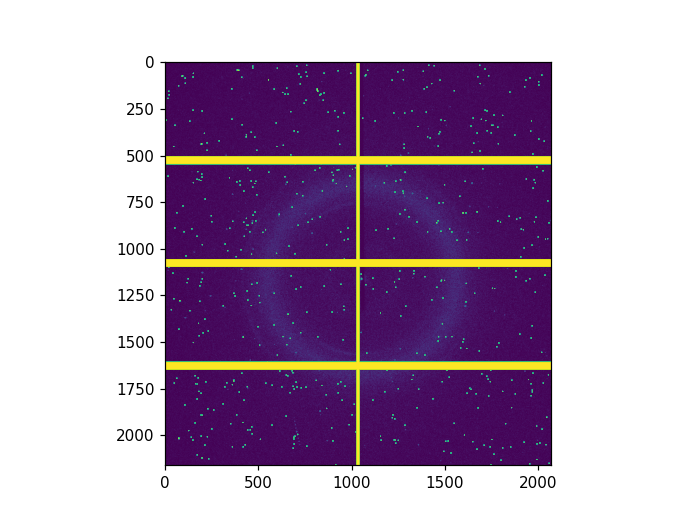

/home/elena/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  


In [6]:
fig = plt.figure()
plt.imshow(image, norm=colors.SymLogNorm(1))

In [7]:
kernel_size = 7
kernel = np.ones((kernel_size, kernel_size))

## Naive approach using `scipy.ndimage.convolve`:

1. explicit initialisation of output

In [8]:
%%timeit
masked_image = image * mask
masked_image2 = masked_image**2

sum_image = ndimage.convolve(masked_image, kernel, mode="constant", cval=0)
sum_sq = ndimage.convolve(masked_image2, kernel, mode="constant", cval=0)
n = ndimage.convolve(mask, kernel, mode="constant", cval=0)

mean_image = np.zeros_like(masked_image, dtype=np.float)  
np.divide(sum_image, n, where=(n > 0), out=mean_image)

inv_count = np.zeros_like(image, dtype=np.float)
np.divide(1, n, where=(n > 0), out=inv_count)

variance_image = (sum_sq - inv_count * sum_image ** 2) * inv_count

dispersion_index = np.zeros_like(masked_image, dtype=np.float)
np.divide(variance_image, mean_image, where=(mean_image > 0), out=dispersion_index)

558 ms ± 2.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2. allow casting but start with float image adds less overhead than the convolution

In [17]:
#%%timeit
fl_image = image.astype(np.float)
masked_image = fl_image * mask
masked_image2 = masked_image**2

sum_image = ndimage.convolve(masked_image, kernel, mode="constant", cval=0)
sum_sq = ndimage.convolve(masked_image2, kernel, mode="constant", cval=0)
n = ndimage.convolve(mask, kernel, mode="constant", cval=0)

mean_image = np.divide(sum_image, n, where=(n > 0))
inv_count = np.divide(1, n, where=(n > 0))
variance_image = (sum_sq - inv_count * sum_image ** 2) * inv_count
dispersion_index = np.divide(variance_image, mean_image, where=(mean_image > 0))

<IPython.core.display.Javascript object>


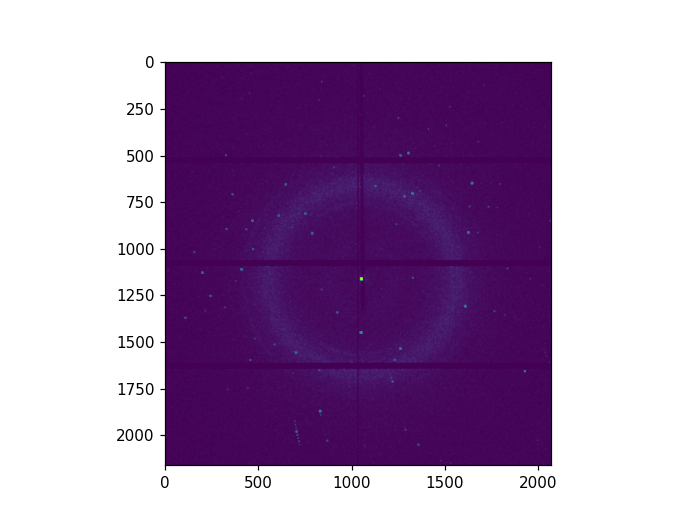

/home/elena/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  


In [18]:
fig = plt.figure()
plt.imshow(variance_image, norm=colors.SymLogNorm(1))

<IPython.core.display.Javascript object>


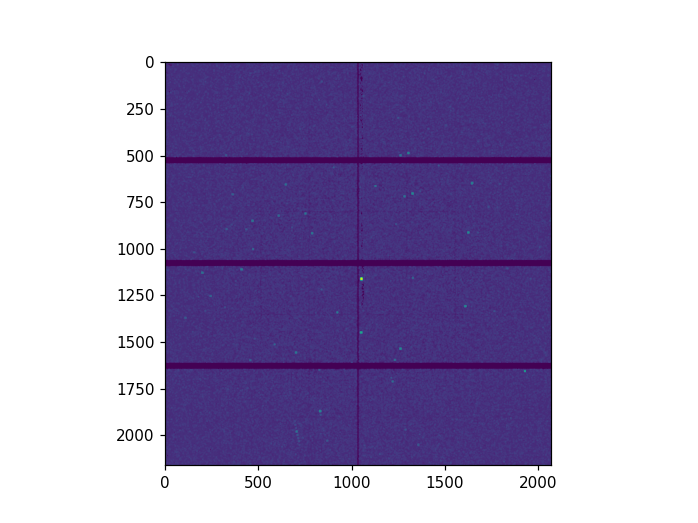

/home/elena/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  


In [19]:
fig = plt.figure()
plt.imshow(dispersion_index, norm=colors.SymLogNorm(1))

## Using `np.cumsum` to calculate the summed area tables:

In [40]:
def summed_area_table(image):
    sat = np.zeros_like(image)
    image.cumsum(axis=0, out=sat).cumsum(axis=1, out=sat)
    return sat

def kernel_sum(image, kernel_size):
    pad = (kernel_size-1)//2
    image = np.pad(image, (pad+1, pad))
    sat = summed_area_table(image)
    #sat = skimage.transform.integral.integral_image(image)
    return (
        sat[:-kernel_size,:-kernel_size] + # top left
        sat[kernel_size:,kernel_size:] - # bottom right
        sat[kernel_size:,:-kernel_size] - # top right
        sat[:-kernel_size,kernel_size:] # bottom left
    )

In [10]:
%%timeit

masked_image = image * mask
masked_image2 = masked_image**2

sum_image = kernel_sum(masked_image, kernel_size)
sum_sq = kernel_sum(masked_image2, kernel_size)
n = kernel_sum(mask, kernel_size)

mean_image = np.divide(sum_image, n, where=(n > 0))
inv_count = np.divide(1, n, where=(n > 0))
variance_image = (sum_sq - inv_count * np.square(sum_image)) * inv_count
dispersion_index = np.divide(variance_image, mean_image, where=(mean_image > 0))

151 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Using `numba` to calculate the summed area tables:

In [45]:
@numba.njit(numba.int32[:,::1](numba.int32[:,::1]))
def summed_area_table(image):
    sat = np.zeros(image.shape, dtype=image.dtype)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            sat[i, j] = image[i, j] + sat[i, j - 1] + sat[i - 1, j] - sat[i - 1, j - 1]
    return sat


def kernel_sum(image, kernel_size):
    pad = (kernel_size-1)//2
    image = np.pad(image, (pad+1, pad))
    sat = summed_area_table(image)
    return (
        sat[:-kernel_size,:-kernel_size] + # top left
        sat[kernel_size:,kernel_size:] - # bottom right
        sat[kernel_size:,:-kernel_size] - # top right
        sat[:-kernel_size,kernel_size:] # bottom left
    )

Separating out computation of the variance made an appreciable difference over using `np.divide`. Note how numba handles division by zero (see `error_model` in https://numba.pydata.org/numba-doc/dev/reference/jit-compilation.html?highlight=error_model)

In [46]:
@numba.njit(error_model="python")
def variance(sum_image, sum_image_sq, n):
    return (sum_image_sq - np.square(sum_image) / n) / n

In [47]:
%%timeit
masked_image = image * mask
masked_image2 = masked_image**2

sum_image = kernel_sum(masked_image, kernel_size)
sum_sq = kernel_sum(masked_image2, kernel_size)
n = kernel_sum(mask, kernel_size)

mean_image = np.divide(sum_image, n, where=(n > 0))
variance_image = variance(sum_image, sum_sq, n)
dispersion_index = np.divide(variance_image, mean_image, where=(mean_image > 0))

10.8 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


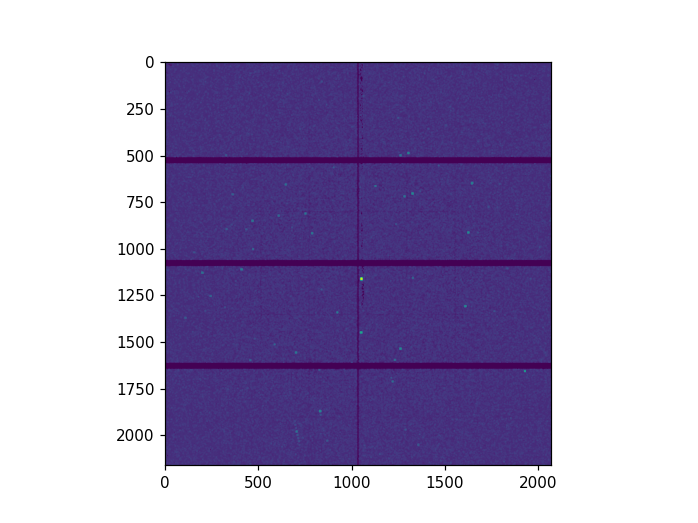

/home/elena/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  


In [16]:
fig = plt.figure()
plt.imshow(dispersion_index, norm=colors.SymLogNorm(1))

We tried calculating the three summed area tables simultaneously (as in the dials source code), but this didn't seem to make any measurable difference.